In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas
import requests
from shapely.geometry import LineString
import json
import os
from tempfile import NamedTemporaryFile
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.transforms as transforms
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from scipy.interpolate import UnivariateSpline

import spiralExtraction

getUrl = lambda id: eval(subjects[subjects['subject_id'] == id]['locations'].iloc[0])['1']

In [3]:
classifications = pandas.read_csv('../classifications/galaxy-builder-classifications_24-7-18.csv')
subjects = pandas.read_csv('../classifications/galaxy-builder-subjects_24-7-18.csv')
null = None
true = True
false = False

most_recent_workflow = classifications.workflow_version == 61.107
classifications[most_recent_workflow].groupby('subject_ids')
classificationsCounts = classifications[most_recent_workflow]['subject_ids'].value_counts()
subjIds = np.array(classificationsCounts[classificationsCounts > 25].index)

print('Identified {} subjects with more than 25 classifications'.format(spiralExtraction.purple(subjIds.shape[0])))

Identified 56 subjects with more than 25 classifications


In [11]:
def getDrawnArms(id):
    annotationsForSubject = [
        eval(foo) for foo in 
        classifications[classifications['subject_ids'] == id]['annotations']
    ]
    try:
        annotationsWithSpiral = [
            c[3]['value'][0]['value']
            for c in annotationsForSubject
            if len(c) > 3 and len(c[3]['value'][0]['value'])
        ]
    except IndexError as e:
        print('{} raised {}'.format(id, e))
        assert False
    spirals = [[a['points'] for a in c] for c in annotationsWithSpiral]
    spiralsWithLengthCut = [
        [[[p['x'], p['y']] for p in a] for a in c]
        for c in spirals if all([len(a) > 5 for a in c])
    ]
    drawnArms = np.array([
        np.array(arm) for classification in spiralsWithLengthCut
        for arm in classification
        if LineString(arm).is_simple
    ])
    return drawnArms

In [13]:
chosenId = 21096912

drawnArms = getDrawnArms(chosenId)
print(len(drawnArms))
distances = spiralExtraction.calculateDistanceMatrix(drawnArms)

33


In [18]:
functions = []
armys = []

db = DBSCAN(
    eps=20,
    min_samples=5,
    metric='precomputed',
    n_jobs=-1,
    algorithm='brute'
).fit(distances)

for label in np.unique(db.labels_):
    if label < 0:
        continue
        
    pointCloud = np.array([
        point for arm in drawnArms[db.labels_ == label]
        for point in arm
    ])

    clf, mask = spiralExtraction.cleanPoints(pointCloud)
    cleanedCloud = pointCloud[mask]

    armyArm = spiralExtraction.findArmyArm(drawnArms[db.labels_ == label], clf)
    armys.append(armyArm)
    
    deviationCloud = np.transpose(
        spiralExtraction.getDistAlongPolyline(cleanedCloud, armyArm)
    )
    pointOrder = np.argsort(deviationCloud[:, 0])

    Sx, Sy = spiralExtraction.fitSmoothedSpline(
        cleanedCloud[pointOrder],
        imageSize=512
    )
    functions.append([Sx, Sy])

    

-1
0
1


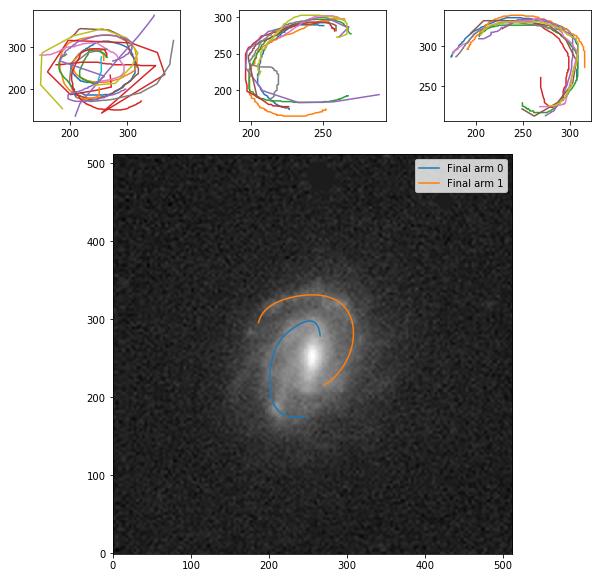

In [24]:
plt.figure(figsize=(10, 10))
grid = plt.GridSpec(4, 3, wspace=0.4, hspace=0.3)
ax0 = plt.subplot(grid[0, 0])
ax1 = plt.subplot(grid[0, 1])
ax2 = plt.subplot(grid[0, 2])
ax3 = plt.subplot(grid[1:, 0:])

for label in np.unique(db.labels_):
    print(label)
    for arm in drawnArms[db.labels_ == label]:
        [ax0, ax1, ax2][label + 1].plot(arm[:, 0], arm[:, 1])

        
url = getUrl(chosenId)
imgData = requests.get(url).content

f = NamedTemporaryFile(suffix='.{}'.format(url.split('.')[-1]), delete=False)
f.write(imgData)
f.close()
pic = Image.open(f.name)
os.unlink(f.name)
ax3.imshow(pic, cmap='gray', origin='lower')

# for i, arm in enumerate(armys):
#     ax3.plot(arm[:, 0], arm[:, 1], label='Smoothed arm-y arm {}'.format(i))

t = np.linspace(0, 1, 1000)
for i, (Sx, Sy) in enumerate(functions):
    ax3.plot((Sx(t)+0.5)*512, (Sy(t)+0.5)*512, label='Final arm {}'.format(i))
    
ax3.legend()